# Minor Flood Frequency
:::{glue:figure} threshold_counts_days_fig
:align: left
:scale: 50%
:::


In this notebook we will plot two indicators concerning flooding at the Hawaii tide gauges, after first taking a general look at the type of data we are able to plot. These indicators are based on a 'flooding' threshold, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html). 

Download Files:
[Map](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_FloodFrequency_map.png) |
[Time Series Plot](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/SL_FloodFrequency_threshold_counts_days.png) |
[Table](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/output/Hawaii_Region_Output/flood_frequency_table.png)



## Setup

We first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. As with our other notebooks, we'll do this by running another notebook called "setup."

In [105]:
%run setup.ipynb


 ##  Retrieve the Tide Station(s) Data Set(s)

We stored this previously in our data directory as "rsl_hawaii.nc"

In [106]:
# load the data
rsl = xr.open_dataset(data_dir / 'rsl_hawaii_noaa.nc')

and we'll save a few variables that will come up later for report generation.

### Set the Datum to MHHW

```{margin} A Note on Datums

The sea level variable in the netcdf file is sea level **relative to the station datum**. 

```

In [107]:
rsl

<xarray.Dataset> Size: 62MB
Dimensions:          (station_id: 7, time: 972999)
Coordinates:
  * time             (time) datetime64[ns] 8MB 1914-01-01T10:00:00 ... 2024-1...
  * station_id       (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 54MB ...
    station_name     (station_id) <U27 756B ...
    station_country  (station_id) <U3 84B ...
    lat              (station_id) float64 56B ...
    lon              (station_id) float64 56B ...
    MHHW             (station_id) float64 56B ...
    MSL              (station_id) float64 56B ...
    MLLW             (station_id) float64 56B ...

In [108]:
# convert sea level to MHHW
rsl['sea_level_MHHW'] = rsl['sea_level'] - rsl['MHHW']
rsl['sea_level_MHHW'].attrs['units'] = 'm'
rsl['sea_level_MHHW'].attrs['long_name'] = 'Sea Level, relative to MHHW'
rsl

<xarray.Dataset> Size: 117MB
Dimensions:          (station_id: 7, time: 972999)
Coordinates:
  * time             (time) datetime64[ns] 8MB 1914-01-01T10:00:00 ... 2024-1...
  * station_id       (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 54MB ...
    station_name     (station_id) <U27 756B ...
    station_country  (station_id) <U3 84B ...
    lat              (station_id) float64 56B ...
    lon              (station_id) float64 56B ...
    MHHW             (station_id) float64 56B ...
    MSL              (station_id) float64 56B ...
    MLLW             (station_id) float64 56B ...
    sea_level_MHHW   (station_id, time) float64 54MB nan nan ... -0.377 -0.335

###  Assess Station Data Quality for the POR (1983-2024)

To do this, we'll plot all the sea level data to make sure our data looks correct, and then we'll truncate the data set to the time period of record (POR).

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in meters! (m)! If we want to plot things on a centimeter (cm) scale, we have to multiply by 100.
```

Text(0, 0.5, 'Sea Level, relative to MHHW (cm, offset by 150cm per station)')

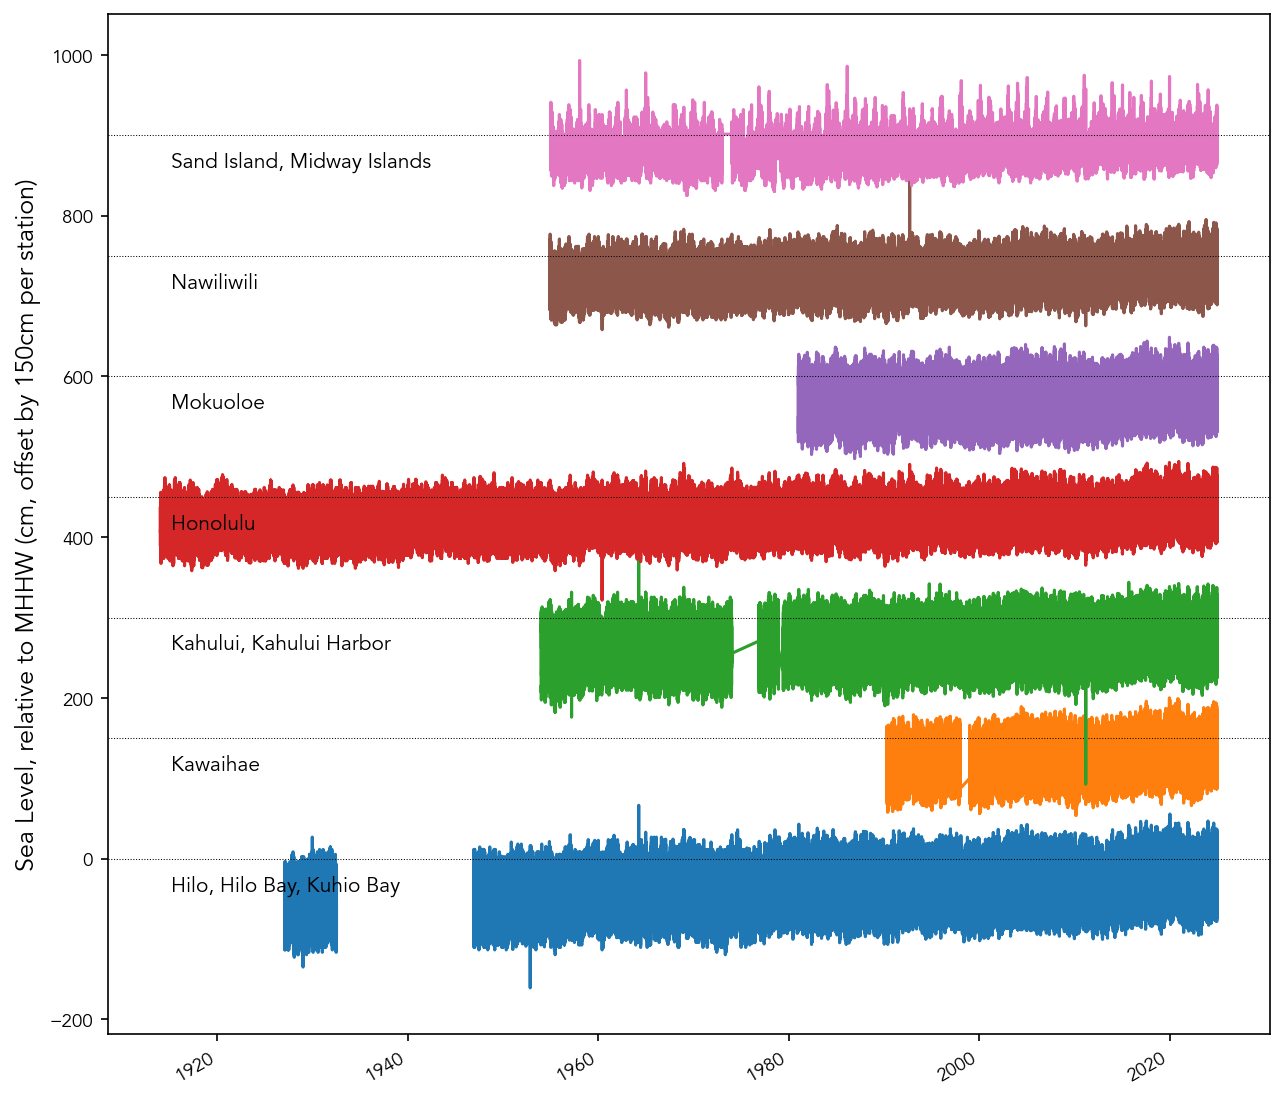

In [109]:
fig, ax = plt.subplots(sharex=True, figsize=(10, 10))
fig.autofmt_xdate()

rsl = rsl.sortby('lat')
# Initial offset
offset = 0
# The amount to offset each successive line
offset_increment = 150  # Adjust this value based on your data scale and visual preference

station_ids = rsl['station_id'].values
station_names = rsl['station_name'].values

for i, (station_id, station_name) in enumerate(zip(station_ids, station_names)):
    sea_level_data = 100 * rsl.sea_level_MHHW.sel(station_id=station_id).values  # cm
    ax.plot(rsl.time.values, sea_level_data + offset, label=station_name)
    ax.axhline(offset, color='black', linewidth=0.5, linestyle=':')
    ax.annotate(
        station_name,
        xy=(rsl.time.values[0], offset-20),
        xytext=(5, 0),
        textcoords='offset points',
        color='black',
        fontsize=10,
        ha='left',
        va='top'
    )
    offset += offset_increment

ax.set_ylabel(rsl['sea_level_MHHW'].long_name + ' (cm, offset by 150cm per station)')




#### Identify timespan for the flood frequency analysis

Now, we'll calculate trend starting from the beginning of the tidal datum analysis period epoch to the last time processed. The  epoch information is given in the datums table. 

In [110]:

# make POR_start equal to Jan 1 1983 in datetime format
POR_start = dt.datetime(1983, 1, 1)

# and for now, end time will be the end of 2024
POR_end = dt.datetime(2024, 12, 31)


hourly_data = rsl.sel(dict(time=slice(POR_start, POR_end)))
hourly_data = hourly_data.sortby('lat')

glue("startPORDateTime",POR_start.strftime('%Y-%m-%d'), display=False)
glue("endPORDateTime",POR_end.strftime('%Y-%m-%d'), display=False)



and plot the hourly time series

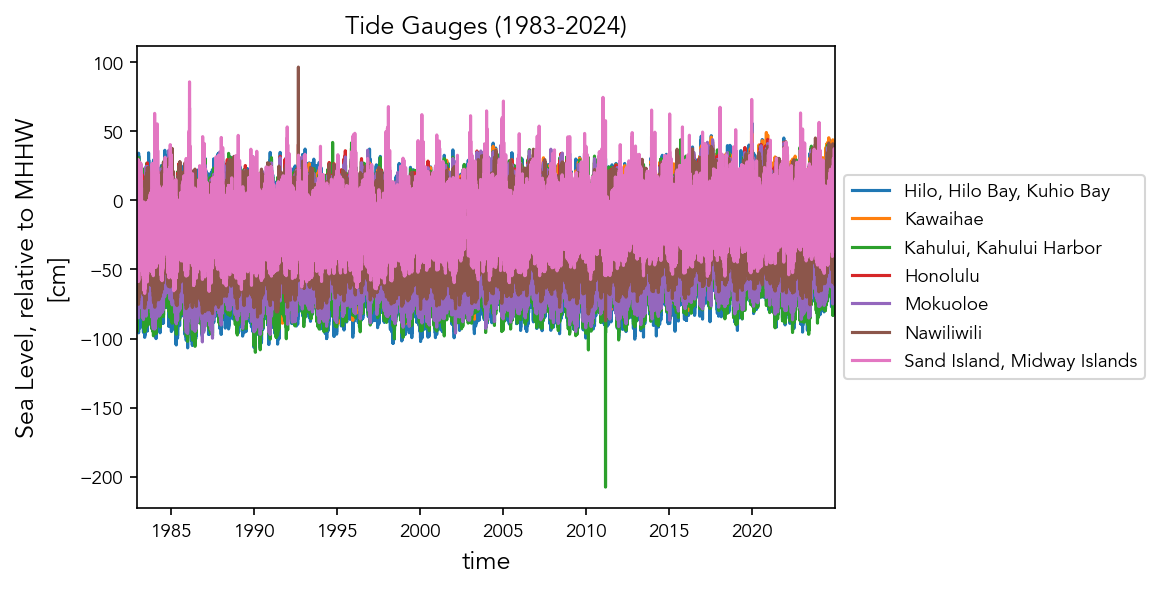

In [111]:
hourly_data['sea_level_MHHW'] = hourly_data['sea_level_MHHW'] * 100

hourly_data['sea_level_MHHW'].attrs['units'] = 'cm'
hourly_data['sea_level_MHHW'].attrs['long_name'] = 'Sea Level, relative to MHHW'

hourly_data['sea_level_MHHW'].plot.line(x='time',label=hourly_data.station_name.values)

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set xlimits
plt.xlim([POR_start, POR_end])

# set title 
titlestr = f'Tide Gauges ({POR_start.strftime("%Y")}-{POR_end.strftime("%Y")})'
plt.title(titlestr)


glue("TS_full_fig",fig,display=False)


:::{glue:figure} TS_full_fig
:name: "fig-TS_full"

Full time series at the {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges for the entire record from {glue:text}`startPORDateTime` to {glue:text}`endPORDateTime`. Note that the sea level is plotted in units of cm, relative to {glue:}`SL_Data_Wrangling.ipynb::datumname`.
:::

### Adjust the data from calendar year to storm year

Storm year goes from May-April. Not going to do it for now.

In [112]:
#IGNORING FOR NOW, DOES HAWAII DO STORM YEAR?

hourly_data['day'] = (('time'), hourly_data.time.dt.dayofyear.data)
hourly_data['month'] = (('time'), hourly_data.time.dt.month.data)    
hourly_data['year'] = (('time'), hourly_data.time.dt.year.data)

# adjust year to storm year, where the storm year starts on May 1st
# if the month is less than 5, subtract a year
hourly_data['year_storm'] = (('time'), hourly_data.year.data - (hourly_data.month.data < 5))

hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

hourly_data['year_storm'].values

# get the year_storm value for April 15, 1997
hourly_data.sel(time='1997-04-15')

<xarray.Dataset> Size: 5kB
Dimensions:          (station_id: 7, time: 24)
Coordinates:
  * time             (time) datetime64[ns] 192B 1997-04-15 ... 1997-04-15T23:...
  * station_id       (station_id) <U7 196B '1617760' '1617433' ... '1619910'
Data variables: (12/13)
    sea_level        (station_id, time) float64 1kB ...
    station_name     (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 84B ...
    lat              (station_id) float64 56B ...
    lon              (station_id) float64 56B ...
    MHHW             (station_id) float64 56B ...
    ...               ...
    MLLW             (station_id) float64 56B ...
    sea_level_MHHW   (station_id, time) float64 1kB -58.2 -59.4 ... -24.8 -26.4
    day              (time) int64 192B 105 105 105 105 105 ... 105 105 105 105
    month            (time) int64 192B 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4
    year             (time) int64 192B 1997 1997 1997 1997 ... 1997 1997 1997
    year_storm       (time) int64 192B 1996 1996 1996 1996 ... 1996 1996 1996

Save the data to the data directory:

In [113]:
# Assuming year_storm is created from the 'time' column
hourly_data['year_storm'] = hourly_data['time'].dt.year
hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

# save the data
hourly_data.to_netcdf(data_dir / 'SL_hourly_data.nc')

## Calculate and Plot Flood Frequency
To analyze flood frequency, we will look for daily maximum sea levels for each day in our dataset, following {cite:t}`thompson_statistical_2019` and others. Then, we can group our data by year and month to visualize temporal patterns in daily SWL exceedance.   

:::{glue:figure} histogram_fig
:name: "fig-histogram"
:figclass: margin

Histogram of daily maximum water levels at the {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges for the entire record from {glue:text}`startPORDateTime` to {glue:text}`endPORDateTime`, relative to {glue:}`SL_Data_Wrangling.ipynb::datumname`. The dashed red line indicates the chosen threshold of {glue:text}`threshold` cm.


:::{margin}
Note this next code block takes a bit of time. Patience!
:::

In [114]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()

# remove time dimension from every variable except sea_level_MHHW
SL_daily_max
timevars = ['sea_level_MHHW','sea_level','flood_day','flood_hour','day','month','year','year_storm']

#remove time from vars that aren't timevars
for var in SL_daily_max.data_vars:
    if var not in timevars:
        SL_daily_max[var] = SL_daily_max[var].isel(time=0)
SL_daily_max

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 15341, station_id: 7)
Coordinates:
  * station_id       (station_id) <U7 196B '1617760' '1617433' ... '1619910'
  * time             (time) datetime64[ns] 123kB 1983-01-01 ... 2024-12-31
Data variables: (12/13)
    sea_level        (time, station_id) float64 859kB 2.219 nan ... 0.92 1.127
    sea_level_MHHW   (time, station_id) float64 859kB 29.2 nan ... -33.5 -7.9
    day              (time) int64 123kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
    month            (time) int64 123kB 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
    year             (time) int64 123kB 1983 1983 1983 1983 ... 2024 2024 2024
    year_storm       (time) int64 123kB 1983 1983 1983 1983 ... 2024 2024 2024
    ...               ...
    station_country  (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 56B 19.73 20.04 20.89 ... 21.95 28.21
    lon              (station_id) float64 56B 204.9 204.2 203.5 ... 200.6 182.6
    MHHW             (station_id) float64 56B 1.927 1.444 1.422 ... 1.255 1.206
    MSL              (station_id) float64 56B 1.545 1.08 1.075 ... 0.949 1.02
    MLLW             (station_id) float64 56B 1.196 0.802 0.736 ... 0.697 0.824

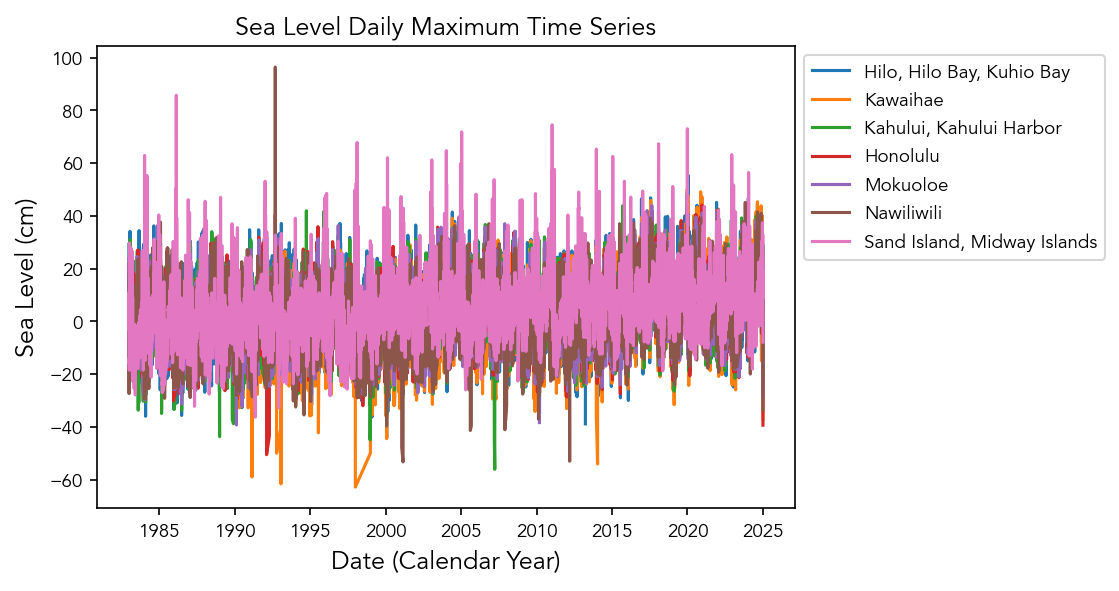

In [115]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True)
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level_MHHW.values,label=SL_daily_max.station_name.values)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

# add legend outside plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# # add a horizontal line at the threshold
# plt.axhline(threshold, color='r', linestyle='--', label='Threshold')


# # Correcting the threshold to find days when sea_level_MHHW is greater than 300 mm
# days_above_threshold = SL_daily_max.where(SL_daily_max.sea_level_MHHW/10 > threshold, drop=True)

# # Highlighting the days above the threshold for each record_id
# for record_id in days_above_threshold.record_id.values:
#     above_threshold_per_record = days_above_threshold.sea_level_MHHW.sel(record_id=record_id)
#     ax.scatter(above_threshold_per_record.time.values, above_threshold_per_record.values / 10)



## Define a flood threshold

Here, we'll define it as the 95th percentile of the daily max water levels. Change at will!

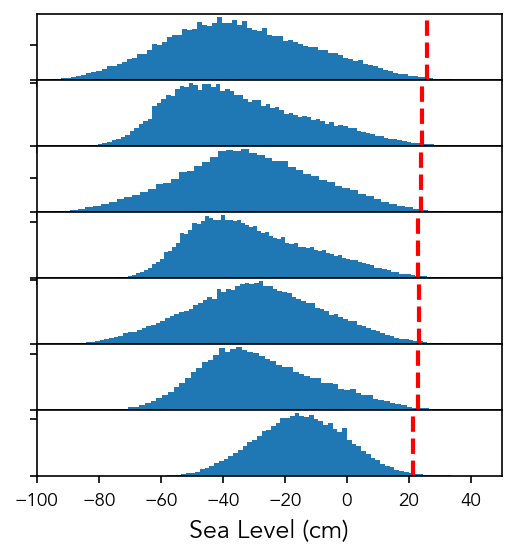

In [116]:
fig, axs = plt.subplots(len(SL_daily_max['station_name']), 1, sharex=True, figsize=(4, 4))

percentile = 95

for i, ax in enumerate(axs):
    ax.hist(hourly_data['sea_level_MHHW'][i,:], bins=100, density=True, label='Sea Level Data')
    ax.axvline(np.nanpercentile(SL_daily_max['sea_level_MHHW'][:,i], percentile), color='r', linestyle='dashed', linewidth=2, label=f'{percentile}th Percentile')

    # remove y-axis label for all
    ax.set_yticklabels('')

axs[-1].set_xlabel('Sea Level (cm)')
plt.subplots_adjust(hspace=0)

# set xlim to -150,75
plt.xlim(-100,50)


#make threshold for (XX))th percentile on each gauge
thresholds = np.nanpercentile(SL_daily_max['sea_level_MHHW'], percentile, axis=0)
glue("threshold_percentile",percentile,display=False)




Let's take a look at what those thresholds are:

In [117]:
# print the tresholds nicely with their stations
for i, station in enumerate(hourly_data['station_name'].values):
    print(f'{station}: {thresholds[i]:.1f} cm')

Hilo, Hilo Bay, Kuhio Bay: 25.8 cm
Kawaihae: 24.3 cm
Kahului, Kahului Harbor: 23.9 cm
Honolulu: 22.9 cm
Mokuoloe: 23.2 cm
Nawiliwili: 23.1 cm
Sand Island, Midway Islands: 21.5 cm


## Adjust threshold to constant value
Now we'll set the threshold to align with NOAA CO-OPS:


In [118]:
url = 'https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/'

threshold_nws = {}
threshold_nos = {}
for station in station_ids:
    thresholds_url = url + f'stations/{station}/floodlevels.json?units=metric'
    thresholdsNOAA = requests.get(thresholds_url).json()
    try:
        nws_minor = thresholdsNOAA['nws_minor']
        nos_minor = thresholdsNOAA['nos_minor']
        mhhw = rsl['MHHW'].sel(station_id=station).item()
        if nws_minor is not None:
            threshold_nws[station] = nws_minor - mhhw
        if nos_minor is not None:
            threshold_nos[station] = nos_minor - mhhw
    except KeyError:
        threshold_nws[station] = None  # or np.nan
        threshold_nos[station] = None  # or np.nan

# multiply by 100 to convert to cm
threshold_nws = {k: v * 100 for k, v in threshold_nws.items() if v is not None}
threshold_nos = {k: v * 100 for k, v in threshold_nos.items() if v is not None}

Note that for the Hawaiian Island region, the NOS minor threshold is 30.4 cm for all stations, whereas the NWS minor threshold varies.

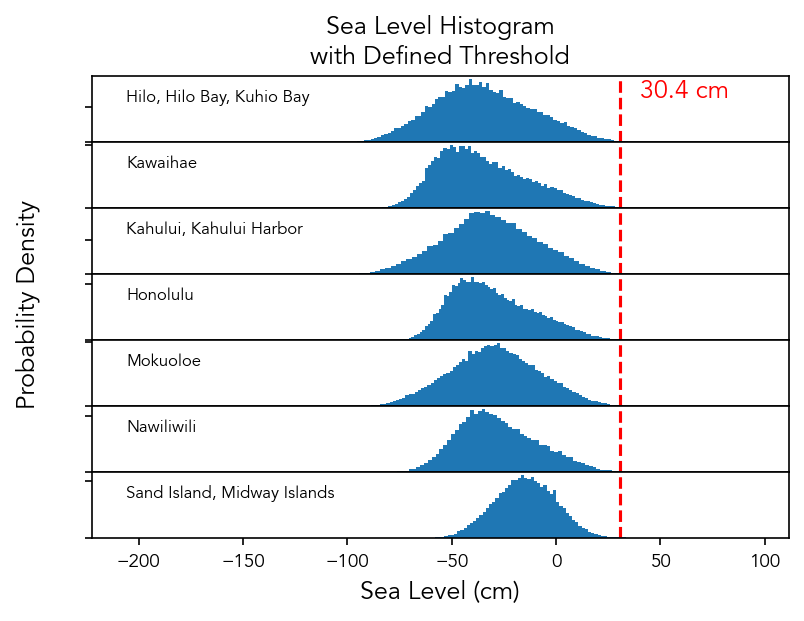

In [119]:
# Make a pdf of the data with NOS minor threshold
fig, axs = plt.subplots(len(hourly_data['station_name']), 1, sharex=True)

for i, ax in enumerate(axs):
    ax.hist(hourly_data['sea_level_MHHW'][i,:], bins=100, density=True, label='Sea Level Data')
    ax.axvline(threshold_nos[station_ids[i]], color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold_nos[station_ids[i]]))

    ax.text(0.05, 0.8, hourly_data['station_name'][i].values, transform=ax.transAxes, fontsize=8, verticalalignment='top')

    # remove y-axis label for all
    ax.set_yticklabels('')

axs[-1].set_xlabel('Sea Level (cm)')
plt.subplots_adjust(hspace=0)


ax.set_xlabel('Sea Level (cm)')
fig.text(0.04, 0.5, 'Probability Density', va='center', rotation='vertical')
# make the title two lines
axs[0].set_title('Sea Level Histogram\nwith Defined Threshold')


# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + yrange/2

axs[0].text(threshold_nos[station_ids[0]]+10, y_middle, '{:.1f} cm'.format(threshold_nos[station_ids[0]]), rotation=0, va='center', ha='left', color='r')
glue("histogram_fig", fig, display=False)

## Define 'flood days' and 'flood hours'

These are the days and hours in which the water levels surpass the given flood threshold. For the following analysis we'll use the 95th percentile values.

In [120]:
flood_day = (SL_daily_max.sea_level_MHHW.values > thresholds)
SL_daily_max

flood_hour = (hourly_data.sea_level_MHHW.values > thresholds[:,None])
flood_hour

# flip the array so that the first dimension is time
flood_hour = np.transpose(flood_hour)

In [121]:
# Add the 'flood_day' variable to the dataset
SL_daily_max['flood_day'] = (('time', 'station_id'), flood_day.data)
SL_daily_max


# Remove 'time' coordinate from 'lat' variable
SL_daily_max['lat'] = hourly_data['lat']
SL_daily_max['lon'] = hourly_data['lon']
SL_daily_max['station_name'] = hourly_data['station_name']
SL_daily_max['station_country'] = hourly_data['station_country']
# SL_daily_max['station_country_code'] = hourly_data['station_country_code']
# SL_daily_max['uhslc_id'] = hourly_data['uhslc_id']
# SL_daily_max['gloss_id'] = hourly_data['gloss_id']
# SL_daily_max['ssc_id'] = hourly_data['ssc_id']
SL_daily_max['MSL'] = hourly_data['MSL']
SL_daily_max['MHHW'] = hourly_data['MHHW']
# SL_daily_max['last_rq_date'] = hourly_data['last_rq_date']


#this is wildly inefficient, needs to be fixed



# Verify the changes
SL_daily_max

# save SL_daily_max to netcdf
SL_daily_max.to_netcdf(data_dir / 'SL_daily_max.nc')

In [122]:


# Filtering for flood days again now that 'flood_day' has been correctly added
flood_days_data = SL_daily_max.where(SL_daily_max.flood_day, drop=True)

# Initialize an empty DataFrame again for the loop
flood_days_per_year = pd.DataFrame()

for station_id in SL_daily_max.station_id.values:
    # Extracting flood days for each station_id
    flood_days_df = flood_days_data.sel(station_id=station_id).dropna(dim='time', how='all').to_dataframe().reset_index()

    # Extract year from the 'time' column and count flood days
    flood_days_df['year'] = flood_days_df['time'].dt.year
    flood_days_count = flood_days_df.groupby('year').size().reset_index(name=station_id)

    # Merge this count with the main DataFrame
    if flood_days_per_year.empty:
        flood_days_per_year = flood_days_count.set_index('year')
    else:
        flood_days_per_year = flood_days_per_year.join(flood_days_count.set_index('year'), how='outer')

# Replace missing values with 0
flood_days_per_year.fillna(0, inplace=True)
flood_days_per_year = xr.DataArray(flood_days_per_year.values, dims=('year', 'station_id'), coords={'year': flood_days_per_year.index, 'station_id': flood_days_per_year.columns})

flood_days_per_year

<xarray.DataArray (year: 42, station_id: 7)> Size: 2kB
array([[ 14.,   0.,   3.,   8.,   6.,   5.,   8.],
       [  9.,   0.,  12.,  18.,  19.,  19.,  13.],
       [  0.,   0.,   3.,   9.,  11.,  32.,   5.],
       [  3.,   0.,   1.,   2.,   2.,   0.,  16.],
       [ 15.,   0.,   7.,   6.,   8.,   4.,  11.],
       [ 16.,   0.,  19.,  21.,  23.,  23.,   7.],
       [  0.,   0.,   2.,   7.,   5.,   3.,   7.],
       [  2.,   1.,   0.,   0.,   0.,   7.,   4.],
       [  9.,   3.,   3.,   9.,   5.,   6.,   2.],
       [ 12.,   0.,  12.,  10.,  16.,   5.,  12.],
       [ 10.,   3.,   6.,   4.,   8.,   2.,  11.],
       [  0.,   0.,   1.,   5.,   2.,   6.,   2.],
       [  3.,   2.,  15.,  21.,  18.,  12.,   9.],
       [ 15.,   3.,  12.,  15.,  12.,   8.,   7.],
       [  8.,   1.,   2.,   0.,   0.,   2.,   3.],
       [  3.,   0.,   0.,   0.,   1.,   0.,  27.],
       [  1.,   4.,   4.,   3.,   3.,   5.,   8.],
       [  0.,   0.,   3.,   3.,   2.,   0.,  12.],
       [ 12.,  10.,  14.,   3.,   7.,   0.,   9.],
       [  4.,   0.,   4.,   0.,   2.,   2.,   7.],
...
       [ 17.,  13.,  24.,  12.,  12.,  15.,  16.],
       [ 17.,  11.,  32.,  20.,  25.,  31.,  12.],
       [ 11.,  17.,  18.,  13.,  20.,  14.,  11.],
       [ 13.,  21.,  22.,  24.,  18.,  21.,  15.],
       [ 12.,   7.,   9.,   5.,   4.,   7.,  25.],
       [  8.,   9.,  12.,  11.,  12.,   6.,  31.],
       [  5.,   2.,   4.,   1.,   1.,   6.,  10.],
       [  1.,   2.,   4.,   0.,   1.,   2.,  59.],
       [  5.,   7.,   5.,   1.,   1.,  10.,  24.],
       [ 19.,  12.,  14.,   7.,  13.,  12.,  37.],
       [ 11.,   7.,   8.,   0.,   0.,  19.,  19.],
       [ 29.,  29.,  24.,  30.,  32.,  36.,   7.],
       [ 56.,  58.,  60.,  69.,  56.,  53.,  25.],
       [ 36.,  31.,  27.,  30.,  30.,  23.,  26.],
       [ 53.,  56.,  41.,  43.,  39.,  38.,  31.],
       [ 95.,  94.,  90., 111.,  95.,  52.,   6.],
       [ 29.,  32.,  19.,  36.,  23.,  31.,  47.],
       [ 19.,  14.,  25.,  15.,  11.,  29.,  52.],
       [ 41.,  52.,  35.,  31.,  32.,  78.,  51.],
       [ 78.,  88.,  88.,  77.,  78.,  99.,  26.]])
Coordinates:
  * year        (year) int32 168B 1983 1984 1985 1986 ... 2021 2022 2023 2024
  * station_id  (station_id) object 56B '1617760' '1617433' ... '1619910'

In [123]:
# Add the 'flood_day' variable to the dataset
hourly_data['flood_hour'] = (('time', 'station_id'), flood_hour.data)
# Filtering for flood days again now that 'flood_hour' has been correctly added
flood_hours_data = hourly_data.where(hourly_data.flood_hour, drop=True)
# Initialize an empty DataFrame again for the loop
flood_hours_per_year = pd.DataFrame()
for station_id in hourly_data.station_id.values:
    # Extracting flood days for each station_id
    flood_hours_df = flood_hours_data.sel(station_id=station_id).dropna(dim='time', how='all').to_dataframe().reset_index()

    # Extract year from the 'time' column and count flood days
    flood_hours_df['year'] = flood_hours_df['time'].dt.year
    flood_hours_count = flood_hours_df.groupby('year').size().reset_index(name=station_id)

    # Merge this count with the main DataFrame
    if flood_hours_per_year.empty:
        flood_hours_per_year = flood_hours_count.set_index('year')
    else:
        flood_hours_per_year = flood_hours_per_year.join(flood_hours_count.set_index('year'), how='outer')
# Replace missing values with 0
flood_hours_per_year.fillna(0, inplace=True)
flood_hours_per_year = xr.DataArray(flood_hours_per_year.values, dims=('year', 'station_id'), coords={'year': flood_hours_per_year.index, 'station_id': flood_hours_per_year.columns})


In [124]:
SL_daily_max

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 15341, station_id: 7)
Coordinates:
  * station_id       (station_id) <U7 196B '1617760' '1617433' ... '1619910'
  * time             (time) datetime64[ns] 123kB 1983-01-01 ... 2024-12-31
Data variables: (12/14)
    sea_level        (time, station_id) float64 859kB 2.219 nan ... 0.92 1.127
    sea_level_MHHW   (time, station_id) float64 859kB 29.2 nan ... -33.5 -7.9
    day              (time) int64 123kB 1 2 3 4 5 6 ... 361 362 363 364 365 366
    month            (time) int64 123kB 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
    year             (time) int64 123kB 1983 1983 1983 1983 ... 2024 2024 2024
    year_storm       (time) int64 123kB 1983 1983 1983 1983 ... 2024 2024 2024
    ...               ...
    lat              (station_id) float64 56B 19.73 20.04 20.89 ... 21.95 28.21
    lon              (station_id) float64 56B 204.9 204.2 203.5 ... 200.6 182.6
    MHHW             (station_id) float64 56B 1.927 1.444 1.422 ... 1.255 1.206
    MSL              (station_id) float64 56B 1.545 1.08 1.075 ... 0.949 1.02
    MLLW             (station_id) float64 56B 1.196 0.802 0.736 ... 0.697 0.824
    flood_day        (time, station_id) bool 107kB True False ... False False

In [125]:
#make new xarray dataset with attributes from SL_daily_max
ds = xr.Dataset()

ds['flood_hours_per_year'] = (('year', 'station_id'), flood_hours_per_year.values)

ds['flood_days_per_year'] = (('year', 'station_id'), flood_days_per_year.values)

ds['flood_days_per_year'].attrs = {'long_name': 'Number of flood days per year', 'units': 'days'}
ds['flood_hours_per_year'].attrs = {'long_name': 'Number of flood hours per year', 'units': 'hours'}

# set year and station_id as coordinates
ds['year'] = flood_hours_per_year.year
ds['station_id'] = flood_hours_per_year.station_id

ds['year'].attrs = {'long_name': 'Year', 'units': 'calendar year'}
ds['station_id'].attrs = {'long_name': 'Station ID', 'units': '1'}


ds['lat'] = SL_daily_max['lat']
ds['lat'].attrs = {'long_name': 'Latitude', 'units': 'degrees_north'}

ds['lon'] = SL_daily_max['lon']
ds['lon'].attrs = {'long_name': 'Longitude', 'units': 'degrees_east'}

ds['station_name'] = SL_daily_max['station_name']
ds['station_name'].attrs = {'long_name': 'Station Name', 'units': '1'}

ds['station_country'] = SL_daily_max['station_country']
ds['station_country'].attrs = {'long_name': 'Station Country', 'units': '1'}



ds



<xarray.Dataset> Size: 6kB
Dimensions:               (year: 42, station_id: 7)
Coordinates:
  * year                  (year) int32 168B 1983 1984 1985 ... 2022 2023 2024
  * station_id            (station_id) <U7 196B '1617760' ... '1619910'
Data variables:
    flood_hours_per_year  (year, station_id) float64 2kB 20.0 0.0 ... 118.0
    flood_days_per_year   (year, station_id) float64 2kB 14.0 0.0 ... 99.0 26.0
    lat                   (station_id) float64 56B 19.73 20.04 ... 21.95 28.21
    lon                   (station_id) float64 56B 204.9 204.2 ... 200.6 182.6
    station_name          (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ...
    station_country       (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'

In [126]:
#find minimum value in flood_days_per_year
min_flood_days = flood_days_per_year.min().min()
max_flood_days = flood_days_per_year.max().max()


### Plot Flood Frequency Counts 

The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year. This plot follows {cite:t}`center_for_operational_oceanographic_products_and_services_us_sea_2014`.

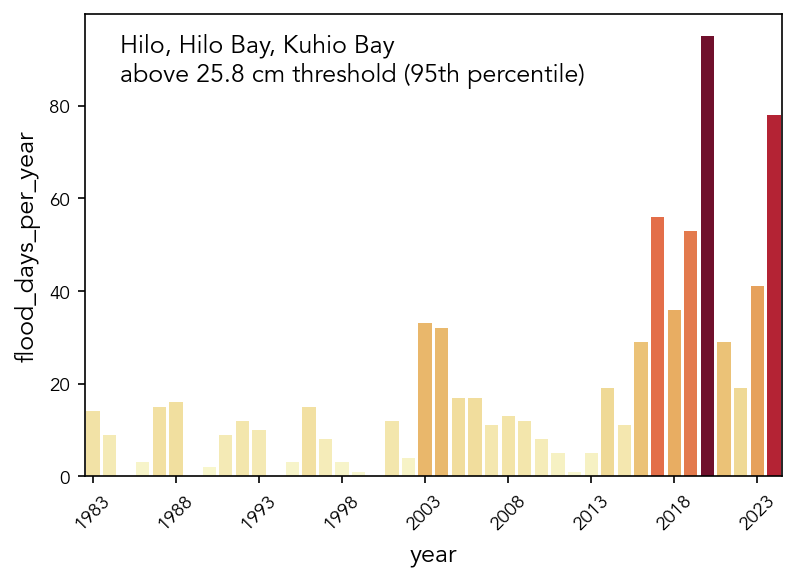

In [127]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

station_id = '1617760'
df = ds['flood_days_per_year'].sel(station_id=station_id).to_dataframe().reset_index()

norm = plt.Normalize(df['flood_days_per_year'].min(), df['flood_days_per_year'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in df['flood_days_per_year']]

threshold = round(thresholds[station_id==ds['station_id'].values].item(), 2)
glue("threshold",threshold,display=False)

# Plotting with the adjusted settings
fig, ax = plt.subplots()


ax = sns.barplot(
    x='year', 
    y='flood_days_per_year', 
    hue='year', 
    data=df,
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(df), 5))  # Setting x-ticks to show every 5th year
year_ticks = df['year'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
station_name = ds['station_name'].sel(station_id=station_id).values.item()

ax.text(0.05, 0.9, station_name + '\nabove ' + str(threshold) + ' cm threshold (' + str(percentile) + 'th percentile)', ha='left', va='center', transform=ax.transAxes)

#save the figure
figname = 'SL_FloodFrequency_threshold_counts_DAYS_'+station_name+'.png'
fig.savefig(output_dir / figname, bbox_inches='tight')

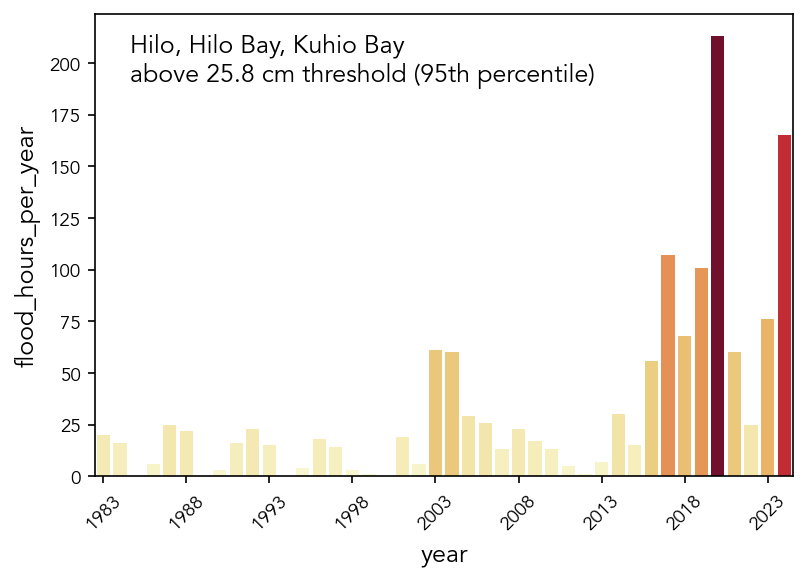

In [128]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)

df = ds['flood_hours_per_year'].sel(station_id=station_id).to_dataframe().reset_index()

norm = plt.Normalize(df['flood_hours_per_year'].min(), df['flood_hours_per_year'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in df['flood_hours_per_year']]


# Plotting with the adjusted settings
fig, ax = plt.subplots()


ax = sns.barplot(
    x='year', 
    y='flood_hours_per_year', 
    hue='year', 
    data=df,
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(df), 5))  # Setting x-ticks to show every 5th year
year_ticks = df['year'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
station_name = ds['station_name'].sel(station_id=station_id).values.item()

ax.text(0.05, 0.9, station_name + '\nabove ' + str(threshold) + ' cm threshold (' + str(percentile) + 'th percentile)', ha='left', va='center', transform=ax.transAxes)

#save the figure
figname = 'SL_FloodFrequency_threshold_counts_HOURS_'+station_name+'.png'
fig.savefig(output_dir / figname, bbox_inches='tight')

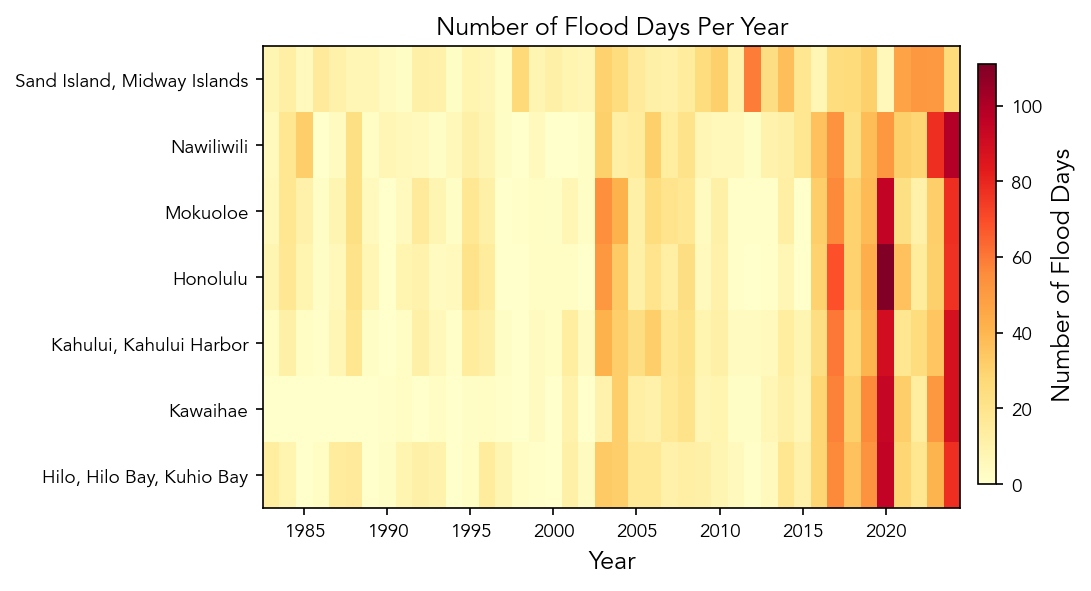

In [129]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_days_per_year.min().min(), flood_days_per_year.max().max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_days_per_year.values]

# do a pcolormesh plot
fig, ax = plt.subplots()
ax.pcolormesh(ds['year'], ds['station_name'], ds['flood_days_per_year'].T, cmap=adjusted_heatmap_palette, norm=norm)

# add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # adjust the position and size of the colorbar
sm = plt.cm.ScalarMappable(cmap=adjusted_heatmap_palette, norm=norm)
plt.colorbar(sm, cax=cax,label= 'Number of Flood Days')

ax.set_xlabel('Year')
ax.set_title('Number of Flood Days Per Year')             

glue("threshold_counts_days_fig", fig, display=False)

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_days.png', bbox_inches='tight')

```{glue:figure} threshold_counts_days_fig
:name: "fig-threshold_counts"

Flood frequency counts above {glue:text}`threshold_percentile:.3f`th percentile threshold per year at {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges from {glue:text}`startPORDateTime` to {glue:text}`endPORDateTime`. 
```

### Plot Flood Duration

This next plot examines the average duration of flooding events as defined by the threshold. 
I have a few issues with this plot being "duration," as it's just counts of hours above the threshold. These hours need not be continuous...which to me is what duration is all about. Anyway, we carry on.

```{margin}
There are some dissimilarities here that give me pause. Going to look into it.
```

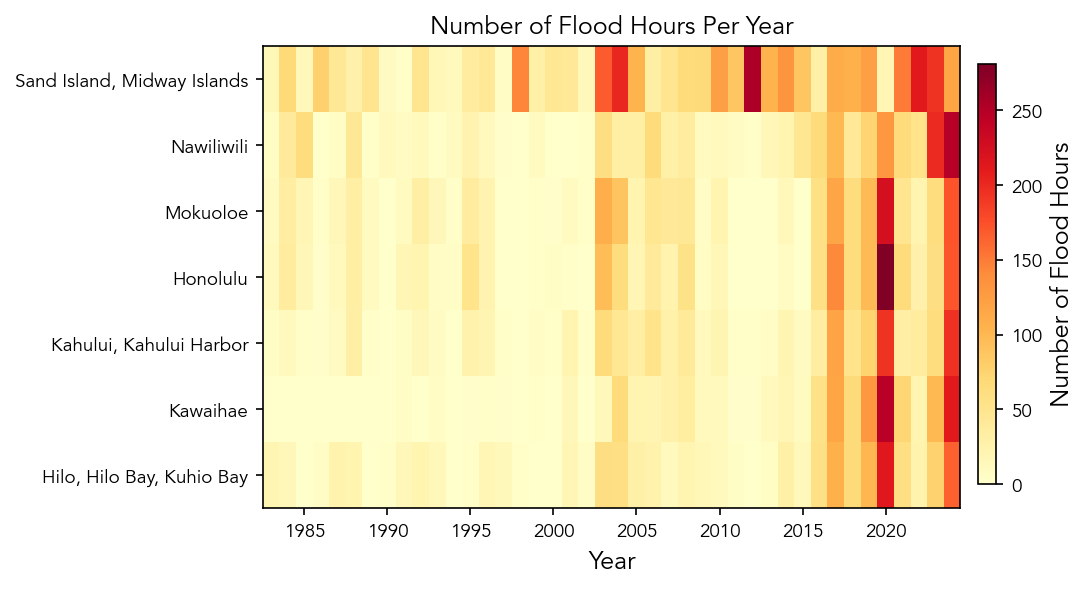

In [130]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_hours_per_year.min().min(), flood_hours_per_year.max().max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_hours_per_year.values]

# do a pcolormesh plot
fig, ax = plt.subplots()
ax.pcolormesh(ds['year'], ds['station_name'], ds['flood_hours_per_year'].T, cmap=adjusted_heatmap_palette, norm=norm)

# add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # adjust the position and size of the colorbar
sm = plt.cm.ScalarMappable(cmap=adjusted_heatmap_palette, norm=norm)
plt.colorbar(sm, cax=cax,label= 'Number of Flood Hours')

ax.set_xlabel('Year')
ax.set_title('Number of Flood Hours Per Year')             
# ax.set_yticklabels(SL_daily_max['station_name'].values[0])

# save the figure
fig.savefig(output_dir / 'SL_FloodFrequency_threshold_counts_hours.png', bbox_inches='tight')



glue("duration_fig", fig, display=False)

```{glue:figure} duration_fig
:name: "fig-duration"

Average flood duration in hours above a threshold of {glue:text}`threshold:.0f` cm per year for {glue:}`SL_Data_Wrangling.ipynb::station_group` region tide gauges from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```

## Calculate the change over time

Next we'll calculate the change in flood days and hours over the POR at the tide station/s, for both Frequency and Duration.

The next code cell fits a trend line to the flood days per year data and calculates the trend line.
The slope of the trend line is the change in flood days per year. The same process is repeated for flood hours per year.


In [131]:

def calculate_flood_trend(ds, timescale = 'days'):

    if timescale == 'days':
        dsvar = 'flood_days_per_year'
    elif timescale == 'hours':
        dsvar = 'flood_hours_per_year'

    slopes = []
    intercepts = []
    rate_changes = []
    
    #trends is an empty array the length of ds['year'] and the number of records
    trends = np.empty((len(ds['year']), len(ds['station_id'])))

    for station_id in range(len(ds['station_id'])):
        slope, intercept, _, _, _ = stats.linregress(ds['year'].values, ds[dsvar].isel(station_id=station_id).values)
        trend = intercept + slope * ds['year']
        # Use slope as the indicator of change (units: days/year or hours/year)
        rate_change = slope
        slopes.append(slope)
        intercepts.append(intercept)
        rate_changes.append(rate_change)
        trends[:, station_id] = trend

    return slopes, intercepts, rate_changes, trends

slopes, intercepts, rate_changes, trends = calculate_flood_trend(ds, 'days')

#add to dataset
ds['slope_days'] = (('station_id'), slopes)
ds['intercept_days'] = (('station_id'), intercepts)
ds['rate_change_days'] = (('station_id'), np.squeeze(rate_changes))
ds['trend_days'] = (('year', 'station_id'), trends)

ds['slope_days'].attrs = {'long_name': 'Slope of the trend line', 'units': 'days/year'}
ds['intercept_days'].attrs = {'long_name': 'Intercept of the trend line', 'units': 'days'}
ds['rate_change_days'].attrs = {'long_name': 'Rate of change in flood days per year', 'units': 'days/year'}
ds['trend_days'].attrs = {'long_name': 'Trend line of flood days per year', 'units': 'days'}


slopes, intercepts, rate_changes, trends = calculate_flood_trend(ds, 'hours')

#add to dataset
ds['slope_hours'] = (('station_id'), slopes)
ds['intercept_hours'] = (('station_id'), intercepts)
ds['rate_change_hours'] = (('station_id'), np.squeeze(rate_changes))
ds['trend_hours'] = (('year', 'station_id'), trends)

ds['slope_hours'].attrs = {'long_name': 'Slope of the trend line', 'units': 'hours/year'}
ds['intercept_hours'].attrs = {'long_name': 'Intercept of the trend line', 'units': 'hours'}
ds['rate_change_hours'].attrs = {'long_name': 'Rate of change in flood hours per year', 'units': 'hours/year'}
ds['trend_hours'].attrs = {'long_name': 'Trend line of flood hours per year', 'units': 'hours'}

ds


<xarray.Dataset> Size: 11kB
Dimensions:               (year: 42, station_id: 7)
Coordinates:
  * year                  (year) int32 168B 1983 1984 1985 ... 2022 2023 2024
  * station_id            (station_id) <U7 196B '1617760' ... '1619910'
Data variables: (12/14)
    flood_hours_per_year  (year, station_id) float64 2kB 20.0 0.0 ... 118.0
    flood_days_per_year   (year, station_id) float64 2kB 14.0 0.0 ... 99.0 26.0
    lat                   (station_id) float64 56B 19.73 20.04 ... 21.95 28.21
    lon                   (station_id) float64 56B 204.9 204.2 ... 200.6 182.6
    station_name          (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ...
    station_country       (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    ...                    ...
    rate_change_days      (station_id) float64 56B 1.029 1.312 ... 1.029 0.7553
    trend_days            (year, station_id) float64 2kB -3.093 -11.86 ... 33.7
    slope_hours           (station_id) float64 56B 2.114 2.924 ... 2.415 2.976
    intercept_hours       (station_id) float64 56B -4.202e+03 ... -5.884e+03
    rate_change_hours     (station_id) float64 56B 2.114 2.924 ... 2.415 2.976
    trend_hours           (year, station_id) float64 2kB -10.42 -28.54 ... 139.4

In [132]:
summary_stats_all = []

for station_idx in range(len(ds['station_id'])):
    station_name = ds['station_name'][station_idx].item()
    station_id = ds['station_id'][station_idx].item()
    stats = {
        'Station Name': station_name,
        'Station ID': station_id,
        'Threshold (cm)': round(thresholds[station_idx],1),
        'Total Flood Days': int(ds['flood_days_per_year'][:, station_idx].sum()),
        'Average Flood Days per Year': round(float(ds['flood_days_per_year'][:, station_idx].mean()), 1),
        'Max Flood Days in a Single Year': int(ds['flood_days_per_year'][:, station_idx].max()),
        'Year of Max Flood Days': int(ds['year'][ds['flood_days_per_year'][:, station_idx].argmax()].item()),
        'Total Flood Hours': int(ds['flood_hours_per_year'][:, station_idx].sum()),
        'Average Flood Hours per Year': round(float(ds['flood_hours_per_year'][:, station_idx].mean()), 1),
        'Max Flood Hours in a Single Year': int(ds['flood_hours_per_year'][:, station_idx].max()),
        'Year of Max Flood Hours': int(ds['year'][ds['flood_hours_per_year'][:, station_idx].argmax()].item()),
        'Change in Flood Days per Year': round(float(ds['rate_change_days'][station_idx]), 1),
        'Change in Flood Hours per Year': round(float(ds['rate_change_hours'][station_idx]), 1  )
    }
    summary_stats_all.append(stats)

summary_stats_df_all = pd.DataFrame(summary_stats_all)
summary_stats_df_all

,Station Name,Station ID,Threshold (cm),Total Flood Days,Average Flood Days per Year,Max Flood Days in a Single Year,Year of Max Flood Days,Total Flood Hours,Average Flood Hours per Year,Max Flood Hours in a Single Year,Year of Max Flood Hours,Change in Flood Days per Year,Change in Flood Hours per Year
0,"Hilo, Hilo Bay, Kuhio Bay",1617760,25.8,756,18.0,95,2020,1382,32.9,213,2020,1.0,2.1
1,Kawaihae,1617433,24.3,631,15.0,94,2020,1319,31.4,248,2020,1.3,2.9
2,"Kahului, Kahului Harbor",1615680,23.9,758,18.0,90,2020,1330,31.7,195,2024,1.0,2.1
3,Honolulu,1612340,22.9,765,18.2,111,2020,1561,37.2,281,2020,0.9,2.2
4,Mokuoloe,1612480,23.2,750,17.9,95,2020,1534,36.5,224,2020,0.8,1.9
5,Nawiliwili,1611400,23.1,767,18.3,99,2024,1616,38.5,249,2024,1.0,2.4
6,"Sand Island, Midway Islands",1619910,21.5,765,18.2,59,2012,3293,78.4,255,2012,0.8,3.0


In [133]:
# # Create a dataframe for statistics for each gauge

# Convert the list of tuples to a pandas DataFrame
summary_stats_df['Value'] = summary_stats_df['Value'].apply(
    lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x)
)
# Turn into a pretty table with great tables
#make a pretty pdf of the table with great_tables
from great_tables import GT, html, style, loc

PORstring = f'{POR_start.strftime("%Y")}-{POR_end.strftime("%Y")}'
floodDaysCols = [col for col in summary_stats_df_all.columns if 'Days' in col]
floodHoursCols = [col for col in summary_stats_df_all.columns if 'Hours' in col]

cols_label_dict = {
    col: html(col.replace("Flood Days", "").replace("Flood Hours", "").strip())
    for col in summary_stats_df_all.columns
}

cols_label_dict['Change in Flood Days per Year'] = html('Change <br> (days/yr)')
cols_label_dict['Change in Flood Hours per Year'] = html('Change <br> (hours/yr)')
cols_label_dict['Max Flood Days in a Single Year'] = html('Yearly Max')
cols_label_dict['Max Flood Hours in a Single Year'] = html('Yearly Max')
cols_label_dict['Station ID'] = html('ID')

# Create a Table object
(
    GT(summary_stats_df_all)
    .tab_options(table_font_size="13px")
    .cols_width(cases={"Station Name": "120px"})
    .cols_label(**cols_label_dict)
    .cols_align(align="left", columns = ['Threshold (cm)','Station ID'])
    .tab_spanner(
        label="Flood Days", columns=floodDaysCols)
    .tab_spanner(
        label="Flood Hours", columns=floodHoursCols)
    .tab_header(
        subtitle='Hawaiian Island Region',title='Minor Flood Statistics')        
    .tab_source_note(
         source_note = 'Data: NOAA CO-OPS Hourly Water Levels (' + PORstring + '), Threshold: ' + str(percentile) +'th percentile of daily max water level')
)

GT(_tbl_data=                  Station Name Station ID  Threshold (cm)  Total Flood Days  \
0    Hilo, Hilo Bay, Kuhio Bay    1617760            25.8               756   
1                     Kawaihae    1617433            24.3               631   
2      Kahului, Kahului Harbor    1615680            23.9               758   
3                     Honolulu    1612340            22.9               765   
4                     Mokuoloe    1612480            23.2               750   
5                   Nawiliwili    1611400            23.1               767   
6  Sand Island, Midway Islands    1619910            21.5               765   

   Average Flood Days per Year  Max Flood Days in a Single Year  \
0                         18.0                               95   
1                         15.0                               94   
2                         18.0                               90   
3                         18.2                              111   
4                         17.9                               95   
5                         18.3                               99   
6                         18.2                               59   

   Year of Max Flood Days  Total Flood Hours  Average Flood Hours per Year  \
0                    2020               1382                          32.9   
1                    2020               1319                          31.4   
2                    2020               1330                          31.7   
3                    2020               1561                          37.2   
4                    2020               1534                          36.5   
5                    2024               1616                          38.5   
6                    2012               3293                          78.4   

   Max Flood Hours in a Single Year  Year of Max Flood Hours  \
0                               213                     2020   
1                               248                     2020   
2                               195                     2024   
3                               281                     2020   
4                               224                     2020   
5                               249                     2024   
6                               255                     2012   

   Change in Flood Days per Year  Change in Flood Hours per Year  
0                            1.0                             2.1  
1                            1.3                             2.9  
2                            1.0                             2.1  
3                            0.9                             2.2  
4                            0.8                             1.9  
5                            1.0                             2.4  
6                            0.8                             3.0  , _body=<great_tables._gt_data.Body object at 0x33ddc6f30>, _boxhead=Boxhead([ColInfo(var='Station Name', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Station Name'), column_align='left', column_width='120px'), ColInfo(var='Station ID', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='ID'), column_align='left', column_width=None), ColInfo(var='Threshold (cm)', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Threshold (cm)'), column_align='left', column_width=None), ColInfo(var='Total Flood Days', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Total'), column_align='right', column_width=None), ColInfo(var='Average Flood Days per Year', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Average  per Year'), column_align='right', column_width=None), ColInfo(var='Max Flood Days in a Single Year', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Yearly Max'), column_align='right', column_width=None), ColInfo(var='Year of Max Flood Days', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Year of Max'), column_align='right', column_width=None), ColInfo(var='Cha

### Plot time series of all stations

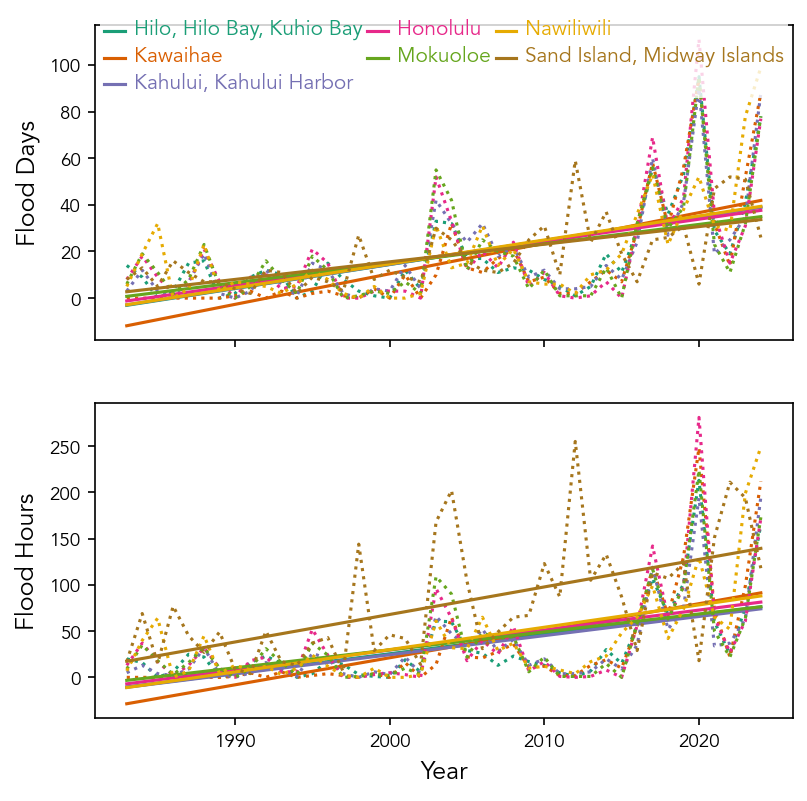

In [134]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(6, 6))

# Set the color for each station
colors = sns.color_palette('Dark2', n_colors=len(ds['station_id']))

# Plot the data for each station with the same color
for i, station_id in enumerate(ds['station_id']):
    axs[0].plot(ds['year'], ds['flood_days_per_year'].sel(station_id=station_id), label=None, color=colors[i], linestyle=':')
    axs[1].plot(ds['year'], ds['flood_hours_per_year'].sel(station_id=station_id), label=None, color=colors[i], linestyle=':')

    # Plot the trend lines
    axs[0].plot(ds['year'], ds['trend_days'].sel(station_id=station_id), label=None , color=colors[i])
    axs[1].plot(ds['year'], ds['trend_hours'].sel(station_id=station_id), label=ds['station_name'].sel(station_id=station_id).values, color=colors[i])

# Set the labels and tick labels
axs[0].set_ylabel('Flood Days')
# axs[0].set_xticklabels([])

axs[1].set_xlabel('Year')
axs[1].set_ylabel('Flood Hours')

# add a legend 
axs[1].legend(ncol=3, columnspacing=0.5, bbox_to_anchor=(0, 2.25), loc='upper left',fontsize=5)

#color the legend text the same as the lines and then remove the lines
for i, station_id in enumerate(ds['station_id']):
    axs[1].get_legend().get_texts()[i].set_color(colors[i])
    axs[1].get_legend().get_texts()[i].set_fontsize('small')
    # axs[1].get_legend().get_lines()[i].set_linewidth(0)

#remove box around legend
axs[1].get_legend().get_frame().set_linewidth(0.0)    


### Create a Table for one Station Only
Now we'll generate a table with this information, which will be saved as a .csv in the output directory specified at the top of this notebook.

In [139]:
import pandas as pd
# make a dataframe with the rate change in flood days and hours per year, with given threshold
rate_change_df = pd.DataFrame({'rate_change_days': ds['rate_change_days'].values, 'rate_change_hours': ds['rate_change_hours'].values, 'threshold': thresholds.round(2)})
rate_change_df = rate_change_df.round(2)
# add the station name and country
rate_change_df['station'] = ds['station_name'].values
rate_change_df['country'] = ds['station_country'].values

# reorder the columns
rate_change_df = rate_change_df[['station', 'threshold', 'rate_change_days', 'rate_change_hours']]

# Define your attributes
attributes = {
    'station': 'Station name',
    'threshold': 'Threshold in cm above MHHW',
    'rate_change_days': 'Rate of change in flood days per year',
    'rate_change_hours': 'Rate of change in flood hours per year'
}

# Open the file in write mode
with open(output_dir / 'SL_FloodFrequency_rate_change.csv', 'w') as f:
    # Write the attributes as comments
    for column, attribute in attributes.items():
        f.write(f'# {column}: {attribute}\n')

    # Write the DataFrame to the file
    rate_change_df.to_csv(f, index=False)

rate_change_df


,station,threshold,rate_change_days,rate_change_hours
0,"Hilo, Hilo Bay, Kuhio Bay",25.8,1.03,2.11
1,Kawaihae,24.3,1.31,2.92
2,"Kahului, Kahului Harbor",23.9,1.02,2.07
3,Honolulu,22.9,0.95,2.16
4,Mokuoloe,23.2,0.83,1.94
5,Nawiliwili,23.1,1.03,2.42
6,"Sand Island, Midway Islands",21.5,0.76,2.98


In [141]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html
thresholdstr = str(percentile) + 'th Percentile'
# Create a Table object
table = (
    GT(rate_change_df[["station", "threshold", "rate_change_days", "rate_change_hours"]])
    .cols_label(
        station=html('Station'),
        threshold=html(f'Threshold<br>{thresholdstr}<br>(cm above MHHW)'),
        rate_change_days=html('Rate of Change<br>in Flood Days<br>(days/yr)'),
        rate_change_hours=html('Rate of Change<br>in Flood Hours<br>(hours/yr)')
    )
    .fmt_number(
        columns=["rate_change_days", "rate_change_hours"], decimals=1
    )
    .tab_header(
            title='Flood Frequency Analysis', subtitle='Hawaiian Island Region')
        .tab_source_note(
            source_note=html(
                f"Data: NOAA CO-OPS Hourly Water Levels. Threshold is calculated with data from {POR_start.strftime('%Y-%m-%d')} to {POR_end.strftime('%Y-%m-%d')} (relative to MHHW)"
            )
        )
)

table
output_path = output_dir / f'flood_frequency_table.png'
table.save(str(output_path), scale=2)

GT(_tbl_data=                       station  threshold  rate_change_days  rate_change_hours
0    Hilo, Hilo Bay, Kuhio Bay       25.8              1.03               2.11
1                     Kawaihae       24.3              1.31               2.92
2      Kahului, Kahului Harbor       23.9              1.02               2.07
3                     Honolulu       22.9              0.95               2.16
4                     Mokuoloe       23.2              0.83               1.94
5                   Nawiliwili       23.1              1.03               2.42
6  Sand Island, Midway Islands       21.5              0.76               2.98, _body=<great_tables._gt_data.Body object at 0x33d9be300>, _boxhead=Boxhead([ColInfo(var='station', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Station'), column_align='left', column_width=None), ColInfo(var='threshold', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Threshold<br>95th Percentile<br>(cm above MHHW)'), column_align='right', column_width=None), ColInfo(var='rate_change_days', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Rate of Change<br>in Flood Days<br>(days/yr)'), column_align='right', column_width=None), ColInfo(var='rate_change_hours', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Rate of Change<br>in Flood Hours<br>(hours/yr)'), column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x36acf43b0>, _spanners=Spanners([]), _heading=Heading(title='Flood Frequency Analysis', subtitle='Hawaiian Island Region', preheader=None), _stubhead=None, _source_notes=[Html(text='Data: NOAA CO-OPS Hourly Water Levels. Threshold is calculated with data from 1983-01-01 to 2024-12-31 (relative to MHHW)')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x33d993840>, _formats=[<great_tables._gt_data.FormatInfo object at 0x36aaf2210>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_i

And here is our final plotting code:

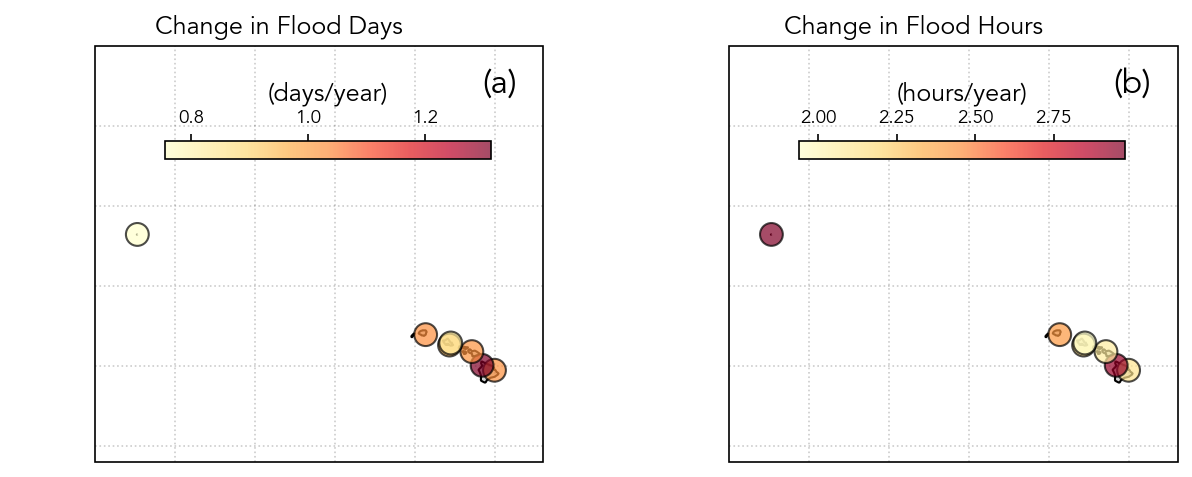

In [168]:
xlims = [-185, -152]
ylims = [14, 40]

crs = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': crs})

rsl['lon_west'] = -(360 - rsl['lon'])

# Colormap setup
cmap_days = plt.get_cmap('YlOrRd')
cmap_hours = plt.get_cmap('YlOrRd')
norm_days = plt.Normalize(ds['slope_days'].min().values, ds['slope_days'].max().values)
norm_hours = plt.Normalize(ds['slope_hours'].min().values, ds['slope_hours'].max().values)

for i, ax in enumerate(axs):
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.text(0.95, 0.95, f'({chr(97 + i)})',
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes,
            fontsize=16)
    # ax.add_feature(cfeature.OCEAN, color='lightblue')
    gl = ax.gridlines(draw_labels=False, linestyle=':', color='black',
                      alpha=0.2, xlocs=ax.get_xticks(), ylocs=ax.get_yticks())
    gl.top_labels = False
    gl.right_labels = False
    if ax == axs[1]:
        gl.left_labels = False

# Plot colored dots for flood days slope
sc_days = axs[0].scatter(
    rsl['lon_west'], rsl['lat'],
    c=ds['slope_days'].values, alpha=0.7,
    cmap=cmap_days, norm=norm_days, s=120, edgecolor='black', transform=crs, zorder=3
)
sc_hours = axs[1].scatter(
    rsl['lon_west'], rsl['lat'],
    c=ds['slope_hours'].values, alpha=0.7,
    cmap=cmap_hours, norm=norm_hours, s=120, edgecolor='black', transform=crs, zorder=3
)

axs[0].set_title('Change in Flood Days')
axs[1].set_title('Change in Flood Hours')

# Add colorbars with custom axes to match figure height and add padding between them
axs_bottom = axs[0].get_position().y0
axs0_x0 = axs[0].get_position().x0
axs0_width = axs[0].get_position().width * 0.9  # slightly shrink width
axs1_x0 = axs[1].get_position().x0
axs1_width = axs[1].get_position().width * 0.9  # slightly shrink width

padding = 0.1  # horizontal gap between colorbars

cbar_ax_days = fig.add_axes([axs0_x0+padding, 0.6, axs0_width-padding, 0.02])  # [left, bottom, width, height]
cbar_ax_hours = fig.add_axes([axs1_x0 + padding, 0.6, axs1_width-padding, 0.02])


cb_days = fig.colorbar(sc_days, cax=cbar_ax_days, label='(days/year)', orientation='horizontal')
cb_hours = fig.colorbar(sc_hours, cax=cbar_ax_hours, label='(hours/year)', orientation='horizontal')

cb_days.ax.xaxis.set_ticks_position('top')
cb_days.ax.xaxis.set_label_position('top')

cb_hours.ax.xaxis.set_ticks_position('top')
cb_hours.ax.xaxis.set_label_position('top')

glue("mag_fig", fig, display=False)
output_file_path = output_dir / 'SL_FloodFrequency_map.png'
fig.savefig(output_file_path, dpi=300, bbox_inches='tight')


```{glue:figure} mag_fig
:name: "mag_fig"

Map of the rate of change in average flood (a) days and (b) hours per year above the {glue:text}`threshold_percentile:.3f`th threshold of water levels at at {glue:}`SL_Data_Wrangling.ipynb::station_group` tide gauges from {glue:text}`startPORDateTime` to {glue:text}`endPORDateTime`
```

---

## Citations

:::{bibliography}
:style: alpha
:filter: docname in docnames
:::